In [22]:
#!pip install pennylane
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "5"
from PIL import Image
from torchsummary import summary
plt.ion()
import pandas as pd
import seaborn as sns

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"

In [24]:
pip install pennylane-lightning[gpu]

  Using cached PennyLane-Lightning-GPU-0.31.0.tar.gz (28 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pennylane-lightning-gpu
Failed to build pennylane-lightning-gpu
  Running setup.py install for pennylane-lightning-gpu: started
  Running setup.py install for pennylane-lightning-gpu: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [57 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      creating build\lib.win-amd64-cpython-310\pennylane_lightning_gpu
      copying pennylane_lightning_gpu\lightning_gpu.py -> build\lib.win-amd64-cpython-310\pennylane_lightning_gpu
      copying pennylane_lightning_gpu\_serialize.py -> build\lib.win-amd64-cpython-310\pennylane_lightning_gpu
      copying pennylane_lightning_gpu\_version.py -> build\lib.win-amd64-cpython-310\pennylane_lightning_gpu
      copying pennylane_lightning_gpu\__init__.py -> build\lib.win-amd64-cpython-310\pennylane_lightning_gpu
      creating build\lib.win-amd64-cpython-310\pennylane_lightning_gpu\src
      copying pennylane_lightning_gpu\src\CMakeLists.txt -> build\lib.win-amd64-cpython-310\pennylane_lightning_gpu\src
      runni

In [23]:
n_qubits =6          # Number of qubits
step = 0.001              # Learning rate
batch_size =15           # Number of samples for each training step
num_epochs =10        # Number of training epochs
q_depth =1               # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.001              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [25]:
dev = qml.device("lightning.qubit", wires=n_qubits)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
data_transforms = {
    'train': transforms.Compose([


        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.3854, 0.3854, 0.3854], [0.4143, 0.4143, 0.4143]),


    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.3854, 0.3854, 0.3854], [0.4143, 0.4143, 0.4143]),


    ]),
    'test': transforms.Compose([

         transforms.Resize((224,224)),
         transforms.ToTensor(),
         transforms.Normalize([0.3854, 0.3854, 0.3854], [0.4143, 0.4143, 0.4143]),

    ]),
}

data_dir ='D:\Prateek\Iterations\PrateekQ'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=15,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes


In [27]:


batch_size = 15
data_dir = 'C:/Users/user/Desktop/Prateek-Q'

# Filter out the .ipynb_checkpoints directory
#class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d != '.ipynb_checkpoints']

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.CenterCrop,
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']
                  if os.path.isdir(os.path.join(data_dir, x)) and x != '.ipynb_checkpoints'}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


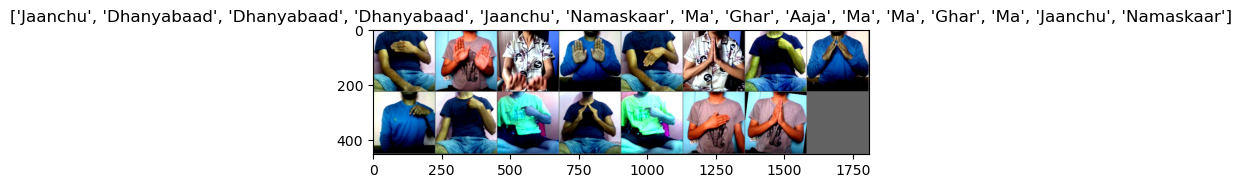

In [7]:
# def imshow(inp, title=None):
#     """Imshow for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.3854, 0.3854, 0.3854])
#     std = np.array([0.4140, 0.4140, 0.4140])
#     inp = std * inp + mean
    
    
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated


# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

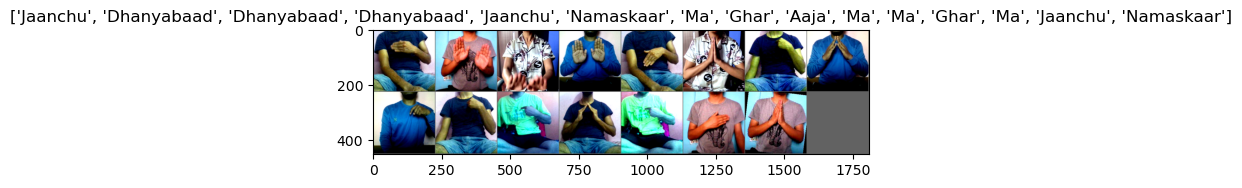

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.3854, 0.3854, 0.3854])
    std = np.array([0.4143, 0.4143, 0.4143])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [29]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    qml.CNOT(wires=[0, 1])
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [30]:
@qml.qnode(dev,diff_method='parameter-shift',interface="torch")
def quantum_net(q_input_features, q_weights_flat):


    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        #entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)


In [31]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.fc1 = nn.Linear(4096,4)
        self.relu=nn.ReLU()
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits,6) #this is for 6 classes

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dime(nsion from 40964
        pre_out= self.fc1(input_features)
        #q_in = torch.tanh(pre_out) * np.pi / 2.0
        q_in=self.relu(pre_out)

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out_elem = q_out_elem.to(device)  # Ensure q_out_elem is on the correct device
            q_out = torch.cat((q_out, q_out_elem))
        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [32]:
model_hybrid = torchvision.models.vgg16(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False




# Notice that model_hybrid.fc is the last layer of alexnet
model_hybrid.classifier[6] = DressedQuantumNet()


# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [33]:
model_hybrid

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
criterion = nn.CrossEntropyLoss().to(device)

In [35]:
optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=0.001)

In [36]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [37]:
tloss=[]
vloss=[]
tacc=[]
vacc=[]

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs): 
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                tloss.append(epoch_loss)
                tacc.append(epoch_acc)
            if phase == 'val':
                vloss.append(epoch_loss)
                vacc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [38]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=10
)

Epoch 0/9
----------
train Loss: 1.1942 Acc: 0.5859
val Loss: 0.6356 Acc: 0.8353

Epoch 1/9
----------
train Loss: 0.8077 Acc: 0.7461
val Loss: 0.3664 Acc: 0.9330

Epoch 2/9
----------
train Loss: 0.6817 Acc: 0.7885
val Loss: 0.4450 Acc: 0.8937

Epoch 3/9
----------
train Loss: 0.7021 Acc: 0.7764
val Loss: 0.3891 Acc: 0.9138

Epoch 4/9
----------
train Loss: 0.7008 Acc: 0.7755
val Loss: 0.4271 Acc: 0.9117

Epoch 5/9
----------
train Loss: 0.6940 Acc: 0.7772
val Loss: 0.3911 Acc: 0.9110

Epoch 6/9
----------
train Loss: 0.7067 Acc: 0.7730
val Loss: 0.4617 Acc: 0.8876

Epoch 7/9
----------
train Loss: 0.7537 Acc: 0.7553
val Loss: 0.4535 Acc: 0.8920

Epoch 8/9
----------
train Loss: 0.7715 Acc: 0.7467
val Loss: 0.4047 Acc: 0.9108

Epoch 9/9
----------
train Loss: 0.7668 Acc: 0.7445
val Loss: 0.4223 Acc: 0.9025

Training complete in 1001m 23s
Best val Acc: 0.932989


In [23]:
device = torch.cuda.current_device()
print("Current CUDA device number:", device)
print("Current CUDA device name:", torch.cuda.get_device_name(device))


Current CUDA device number: 0
Current CUDA device name: NVIDIA GeForce RTX 2080 Ti


In [19]:
tacc= [tensor.tolist() for tensor in tacc]
vacc= [tensor.tolist() for tensor in vacc]


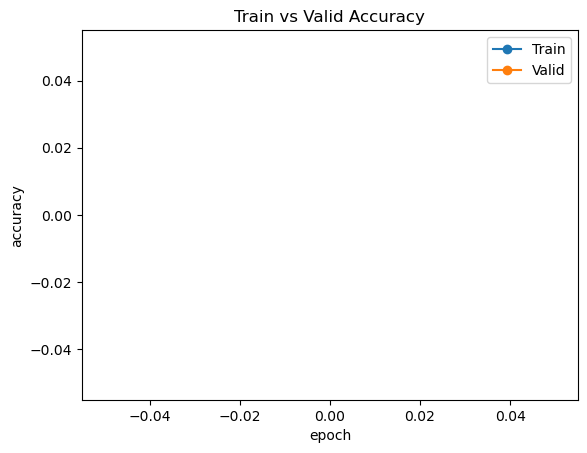

In [20]:

plt.plot(tacc,'-o')
plt.plot(vacc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

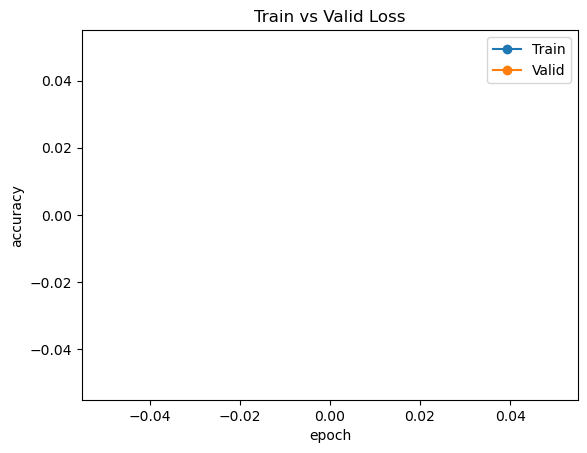

In [21]:
plt.plot(tloss,'-o')
plt.plot(vloss,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')

plt.show()